# Mid Term Project
by:
Srini and Denny

<a id='content'></a>
### Table of content
<a href='#setup'>setup libraries</a>
- pandas, numpy
- sklearn

<a href='#helper_function'>helper functions</a>
- plot data

<a href='#data_functions'>data functions</a>
- interquartile
- droping tables
- transformation

<a href='#raw_data'>raw data</a>
- loading raw data
<li>
    <a href='#plot_raw'>plot raw data</a>
    <li>
    <a href='#heatmap'>heatmap</a>
    </li>
</li>

<a href='#analyze_raw_data'>analyze Raw Data</a>

<a href='#plot_regression'>plot regression graph</a>

<a href='#feature_importance'>feature importance</a>

<a href='#content'>back to content list</a>
<a id='setup'></a> 
### Setup

In [1312]:
# import libraries

# dealing with data libs
import pandas as pd
import numpy as np


# dealing with date 
import datetime

# plotting libs
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm.notebook import tqdm # progressbar for looping


# machine learning libs
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder, PowerTransformer, MinMaxScaler,RobustScaler
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

import statsmodels.api as sm





<a href='#content'>back to content list</a>
<a id='helper_function'></a> 
### Helper Functions

In [1313]:
# ploting all numerical data from dataframe

def plot_numeric(data):
    for i in data._get_numeric_data():
        fig , ax = plt.subplots(1,2, figsize=(15,7))
        plt.title(i)
        sns.boxplot(x=data[i], ax=ax[0])
        sns.histplot(data[i], ax=ax[1])

        plt.show()

<a id='data_functions'></a>
<a href='#content'>back to content list</a>
### Functions for optional data handling:

#### option 1 Interquartile

In [1314]:
# rip data in interquartile range

def reduce_to_interquartile(data: pd.DataFrame, name: list) -> pd.DataFrame:
    Q1 = data[name].quantile(0.25)
    Q3 = data[name].quantile(0.75)
    IQR = Q3 - Q1    #IQR is interquartile range.
    filter = (data[name] >= Q1 - 1.5 * IQR) & (data[name] <= Q3 + 1.5 *IQR)
    data=data.loc[filter] 

    return data

#### option 2 remove

In [1315]:
# remove column

def remove_column(data: pd.DataFrame, name: list) -> pd.DataFrame:
    data = data.drop(columns=name, inplace= True)

    return data

#### perform transformation operation on data

In [1316]:
# transform operation

pwr = PowerTransformer()
robust = RobustScaler()
minMax = MinMaxScaler()

def aggregate_transform(data: pd.DataFrame, name: str, operator: str = 'pwr', lamda_value: float = 0)-> pd.DataFrame:
    transformer = pwr

    if operator == 'pwr':
        transformer = pwr
    elif operator == 'minmax':
        transformer = minMax
    elif operator == 'robust':
        transformer = robust
    if lamda_value != 0:
        transformer.lambdas_ = lamda_value
    data[name] = transformer.fit_transform(data[name].to_numpy().reshape(-1,1))
    return data


#### plot function 

In [1317]:
# Make an scatter plot y_pred vs y
# What kind of plot you will get if all the all the predictions are ok?
# A stright line
def plot_train_vs_test(x_train, y_pred, x_test, y_test, y_pred_train):
    fig, ax = plt.subplots(2,3,figsize=(18,10))
    ax[0,0].plot(y_pred, y_test, 'o',color='red')
    ax[0,0].set_xlabel("y_test")
    ax[0,0].set_ylabel("y_pred")
    ax[0,0].set_title("Test Set -Predicted vs real")

    # Get a histogram of the residuals ie: y - y_pred.  Homoscdasticity
    # It resembles a normal distribution?
    ax[0,1].hist(y_test - y_pred, color='red')
    ax[0,1].set_xlabel("Test y-y_pred")
    ax[0,1].set_title("Test Set Residual histogram")

    ax[0,2].plot(y_pred,y_test - y_pred,"o", color='red')
    ax[0,2].set_xlabel("predited")
    ax[0,2].set_ylabel("residuals")
    ax[0,2].set_title("Residuals by Predicted")
    ax[0,2].plot(y_pred,np.zeros(len(y_pred)),linestyle='dashed')



    ax[1,0].plot(y_pred_train, y_train, 'o')
    ax[1,0].set_xlabel("y_train")
    ax[1,0].set_ylabel("y_pred_train")
    ax[1,0].set_title("Train set Predicted vs real")

    # Get a histogram of the residuals ie: y - y_pred.  Homoscdasticity
    # It resembles a normal distribution?
    ax[1,1].hist(y_train - y_pred_train)
    ax[1,1].set_xlabel("Train y-y_pred")
    ax[1,1].set_title("Train Residual histogram")

    ax[1,2].plot(y_pred_train,y_train - y_pred_train,"o")
    ax[1,2].set_xlabel("predited")
    ax[1,2].set_ylabel("residuals")
    ax[1,2].set_title("Residuals by Predicted -- Train set")
    ax[1,2].plot(y_pred_train,np.zeros(len(y_pred_train)),linestyle='dashed')
    

<a id='raw_data'></a>
<a href='#content'>back to content list</a>
### load raw data

In [1318]:
# load data and create work_copy

raw_data = pd.read_excel('../data/Data_MidTerm_Project_Real_State_Regression.xls')

work_copy = raw_data.copy()


### Data review

In [1319]:
raw_data.head()

,id,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,...,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,price
0,7129300520,2014-10-13,3,1.00,1180,5650,1.0,0,0,3,...,1180,0,1955,0,98178,47.5112,-122.257,1340,5650,221900
1,6414100192,2014-12-09,3,2.25,2570,7242,2.0,0,0,3,...,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639,538000
2,5631500400,2015-02-25,2,1.00,770,10000,1.0,0,0,3,...,770,0,1933,0,98028,47.7379,-122.233,2720,8062,180000
3,2487200875,2014-12-09,4,3.00,1960,5000,1.0,0,0,5,...,1050,910,1965,0,98136,47.5208,-122.393,1360,5000,604000
4,1954400510,2015-02-18,3,2.00,1680,8080,1.0,0,0,3,...,1680,0,1987,0,98074,47.6168,-122.045,1800,7503,510000


<a id='plot_raw'></a>
<a href='#content'>back to content list</a>
### Plotting raw data

In [1320]:
# analyze raw data
# plot_numeric(work_copy)
#sns.pairplot(work_copy,diag_kind="kde")

<a id='heatmap'></a>
<a href='#content'>back to content list</a>

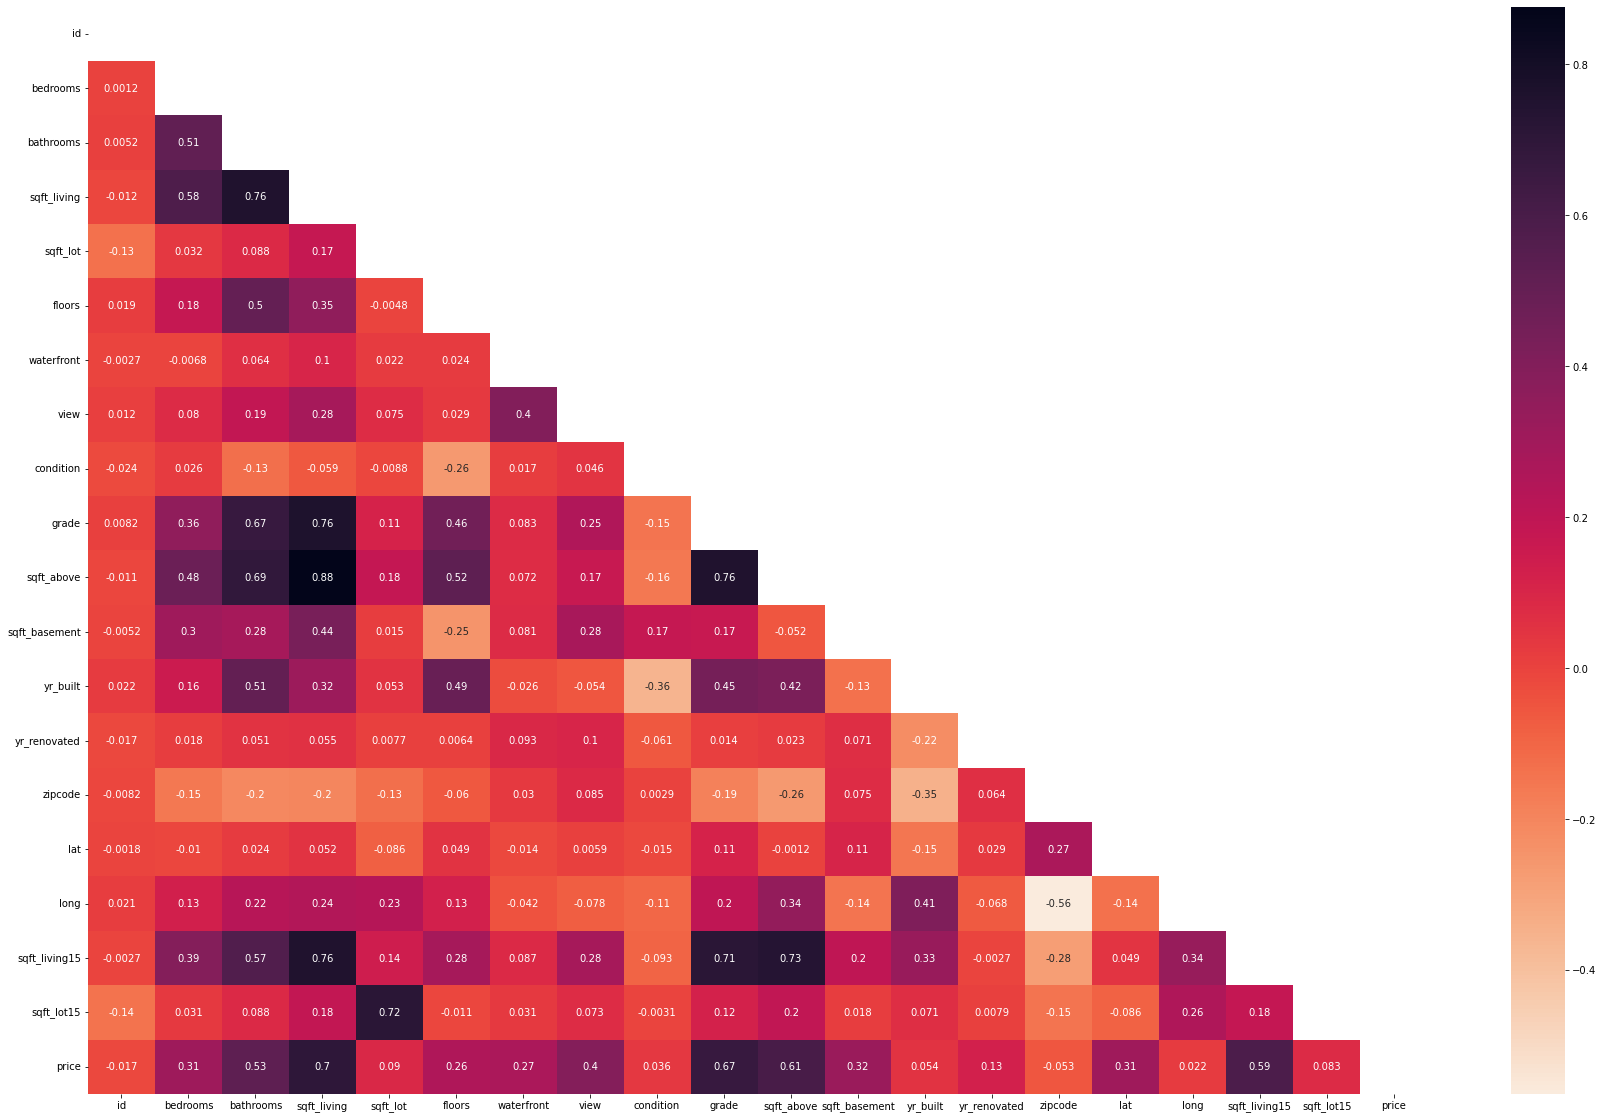

In [1321]:
cmap = sns.cm.rocket_r  ## for reversing the colors
mask=np.zeros_like(work_copy._get_numeric_data().corr())
mask[np.triu_indices_from(mask)]=True
fig, ax=plt.subplots(figsize=(30, 20))
ax=sns.heatmap(work_copy._get_numeric_data().corr(), mask=mask, annot=True,cmap=cmap)
plt.show()

<a id='analyze_raw_data'></a>
<a href='#content'>back to content list</a>
### **Data description:** 

> id -> will be removed as not mandatory
>
> bedrooms -> need adjustments as max 33 could be an outlayer, without -> normal distributed
>
> bathrooms -> max 8 needs to check, if its fits with connected sqft range ->
>
> sqft_living -> maybe recalculated in square meter to fit better in european perspective
>
> sqft_lot -> similar to sqft_living
>
> floors -> maybe changable to ordonal categorical
>
> waterfront -> set to categorical 
>
> view -> needs review why min to 75% is zero with an max of 4
>
> condition -> transform to ordonal categorical 0-5
>
> grade -> as descripted typical ordonal categorical 0-13
>
> sqft_above -> similar to sqft_living
>
> sqft_basement -> similar to sqft_living
> - as sqft_basement looks without zero numbers as normal distributed
> - ***ToDo:*** drop zero values from this column
> - create category 'has_basement'
> - fill all 'has_basement' where basement is included
>
> yr_build -> use as number or could be ordonal category when binning with steps e.g 5 years 1900-1905 ....
>
> zip code, lat and long -> skipt or could binning or clustered to regions 
>
> sqft_living15 and sqft_lot15 represents the average living and lot sqft of the closest 15 neiboorhouses





In [1322]:
# drop first not need data
work_copy.drop(columns=['id', 'date', 'sqft_lot','sqft_above', 'view', 'floors', 'yr_renovated','sqft_living15', 'sqft_lot15'], inplace=True)

In [1323]:
work_copy.drop(columns=['long', 'lat'], inplace=True)

In [1324]:
# interquartile sqft_living

#work_copy =  work_copy[work_copy['bedrooms'] != 33]

#work_copy = reduce_to_interquartile(data=work_copy, name='price')

work_copy = reduce_to_interquartile(data=work_copy, name='bedrooms')
#work_copy = reduce_to_interquartile(data=work_copy, name='sqft_living')
#work_copy = reduce_to_interquartile(data=work_copy, name='bathrooms')
#work_copy = reduce_to_interquartile(data=work_copy, name='long')
#work_copy = reduce_to_interquartile(data=work_copy, name='lat')


#work_copy = aggregate_transform(data= work_copy, name= 'yr_built', operator='pwr')
#work_copy = aggregate_transform(data=work_copy, name='grade', operator='pwr')
#work_copy = aggregate_transform(data=work_copy, name='lat', operator='pwr')
#work_copy = aggregate_transform(data=work_copy, name='waterfront', operator='pwr')
#work_copy = aggregate_transform(data=work_copy, name='sqft_living', operator='minmax')

In [1325]:
# basement has no real influence so i transform this to an binary has or has not field 0 or 1
work_copy['sqft_basement'].values[work_copy['sqft_basement'] != 0] = 1


In [1326]:
work_copy = pd.get_dummies(work_copy, columns=['zipcode'], drop_first=True)

In [1327]:
#plot_numeric(work_copy)

#sns.pairplot(work_copy,diag_kind="kde")

In [1328]:
work_copy.describe()

,bedrooms,bathrooms,sqft_living,waterfront,condition,grade,sqft_basement,yr_built,price,zipcode_98002,...,zipcode_98146,zipcode_98148,zipcode_98155,zipcode_98166,zipcode_98168,zipcode_98177,zipcode_98178,zipcode_98188,zipcode_98198,zipcode_98199
count,21067.000000,21067.000000,21067.000000,21067.000000,21067.000000,21067.000000,21067.000000,21067.000000,2.106700e+04,21067.000000,...,21067.000000,21067.000000,21067.000000,21067.000000,21067.000000,21067.000000,21067.000000,21067.000000,21067.000000,21067.000000
mean,3.347653,2.108618,2070.654673,0.007310,3.410215,7.665021,0.390469,1971.408079,5.374412e+05,0.008924,...,0.013054,0.002706,0.020791,0.011677,0.012484,0.011772,0.012199,0.006266,0.012959,0.014715
std,0.800521,0.746090,889.352191,0.085188,0.648996,1.159440,0.487867,29.210838,3.555173e+05,0.094046,...,0.113507,0.051947,0.142687,0.107430,0.111035,0.107861,0.109777,0.078910,0.113099,0.120412
min,2.000000,0.500000,440.000000,0.000000,1.000000,4.000000,0.000000,1900.000000,7.800000e+04,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.000000,1.750000,1430.000000,0.000000,3.000000,7.000000,0.000000,1952.000000,3.225000e+05,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,3.000000,2.250000,1910.000000,0.000000,3.000000,7.000000,0.000000,1975.000000,4.500000e+05,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,4.000000,2.500000,2530.000000,0.000000,4.000000,8.000000,1.000000,1997.000000,6.400000e+05,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,5.000000,6.750000,10040.000000,1.000000,5.000000,13.000000,1.000000,2015.000000,7.060000e+06,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### First Approach with unfilterd data

In [1329]:
label = work_copy['price']
work_copy.drop(columns='price', inplace=True)

In [1330]:
x_train, x_test, y_train, y_test = train_test_split(work_copy, label, test_size= 0.1, random_state= 42)

In [1331]:
x_train.describe()

,bedrooms,bathrooms,sqft_living,waterfront,condition,grade,sqft_basement,yr_built,zipcode_98002,zipcode_98003,...,zipcode_98146,zipcode_98148,zipcode_98155,zipcode_98166,zipcode_98168,zipcode_98177,zipcode_98178,zipcode_98188,zipcode_98198,zipcode_98199
count,18960.000000,18960.000000,18960.000000,18960.000000,18960.000000,18960.000000,18960.000000,18960.000000,18960.000000,18960.000000,...,18960.000000,18960.000000,18960.000000,18960.000000,18960.000000,18960.000000,18960.000000,18960.000000,18960.000000,18960.000000
mean,3.350949,2.109072,2073.175686,0.007437,3.411129,7.665348,0.390770,1971.487342,0.008808,0.012816,...,0.013291,0.002795,0.020675,0.011551,0.013186,0.011603,0.012184,0.006435,0.013449,0.014873
std,0.800231,0.746179,889.470069,0.085917,0.650490,1.159964,0.487936,29.205770,0.093439,0.112485,...,0.114522,0.052799,0.142298,0.106854,0.114072,0.107095,0.109708,0.079960,0.115192,0.121049
min,2.000000,0.500000,440.000000,0.000000,1.000000,4.000000,0.000000,1900.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.000000,1.750000,1430.000000,0.000000,3.000000,7.000000,0.000000,1952.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,3.000000,2.250000,1910.000000,0.000000,3.000000,7.000000,0.000000,1976.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,4.000000,2.500000,2540.000000,0.000000,4.000000,8.000000,1.000000,1997.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,5.000000,6.750000,10040.000000,1.000000,5.000000,13.000000,1.000000,2015.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [1332]:
scaler_train = StandardScaler().fit(x_train)
#scaler_train = RobustScaler().fit(x_train)
#scaler_train = MinMaxScaler().fit(x_train)



scaler_train.transform(x_train)
#scaler_train.transform(x_test)


array([[ 2.06077136,  0.5239203 ,  1.06450944, ..., -0.08047528,
        -0.11675923, -0.12287382],
       [ 2.06077136,  2.19916463,  1.75032913, ..., -0.08047528,
        -0.11675923, -0.12287382],
       [ 0.81109999,  0.5239203 ,  0.64852045, ..., -0.08047528,
        -0.11675923, -0.12287382],
       ...,
       [-0.43857138, -1.48637291, -0.89176312, ..., -0.08047528,
        -0.11675923, -0.12287382],
       [-0.43857138, -1.48637291, -1.03792141, ..., -0.08047528,
        -0.11675923, -0.12287382],
       [ 0.81109999, -0.14617744, -0.4195594 , ..., -0.08047528,
        -0.11675923, -0.12287382]])

In [1333]:
model_l = LinearRegression()
#model_l = Lasso()

model_l.fit(x_train, y_train)

LinearRegression()

In [1334]:
y_pred = model_l.predict(x_test)
y_pred_train = model_l.predict(x_train)

In [1335]:
x_train_sm = sm.add_constant(x_train) # adding a constant
model = sm.OLS(list(y_train), x_train_sm).fit()

model.summary()


/opt/anaconda3/envs/DA_Enviroment/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.801
Model:                            OLS   Adj. R-squared:                  0.800
Method:                 Least Squares   F-statistic:                     986.1
Date:                Tue, 16 Nov 2021   Prob (F-statistic):               0.00
Time:                        12:51:04   Log-Likelihood:            -2.5404e+05
No. Observations:               18960   AIC:                         5.082e+05
Df Residuals:                   18882   BIC:                         5.088e+05
Df Model:                          77                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const          1.999e+06   1.22e+05     16.436      0.000    1.76e+06    2.24e+06
bedrooms      -3.221e+04   1883.134    -17.103      0.000   -3.59e+04   -2.85e+04
bathrooms      2.183e+04   2766.459      7.889      0.000    1.64e+04    2.72e+04
sqft_living     197.6275      2.779     71.116      0.000     192.181     203.075
waterfront     8.004e+05    1.4e+04     57.153      0.000    7.73e+05    8.28e+05
condition      2.133e+04   2007.554     10.625      0.000    1.74e+04    2.53e+04
grade          7.078e+04   1853.923     38.178      0.000    6.71e+04    7.44e+04
sqft_basement  -3.44e+04   2719.018    -12.653      0.000   -3.97e+04   -2.91e+04
yr_built      -1315.2142     62.104    -21.178      0.000   -1436.943   -1193.485
zipcode_98002  2.027e+04   1.53e+04      1.325      0.185   -9714.324    5.02e+04
zipcode_98003 -1.529e+04   1.36e+04     -1.123      0.261    -4.2e+04    1.14e+04
zipcode_98004  7.716e+05   1.32e+04     58.426      0.000    7.46e+05    7.97e+05
zipcode_98005  2.909e+05   1.63e+04     17.873      0.000    2.59e+05    3.23e+05
zipcode_98006  2.758e+05    1.2e+04     22.981      0.000    2.52e+05    2.99e+05
zipcode_98007  2.238e+05   1.74e+04     12.881      0.000     1.9e+05    2.58e+05
zipcode_98008  2.544e+05   1.36e+04     18.750      0.000    2.28e+05    2.81e+05
zipcode_98010  7.353e+04   1.88e+04      3.918      0.000    3.67e+04     1.1e+05
zipcode_98011  1.083e+05   1.52e+04      7.147      0.000    7.86e+04    1.38e+05
zipcode_98014  1.076e+05   1.79e+04      5.998      0.000    7.24e+04    1.43e+05
zipcode_98019  7.783e+04   1.53e+04      5.084      0.000    4.78e+04    1.08e+05
zipcode_98022  2.778e+04   1.44e+04      1.928      0.054    -463.991     5.6e+04
zipcode_98023 -3.859e+04   1.17e+04     -3.291      0.001   -6.16e+04   -1.56e+04
zipcode_98024  1.722e+05   2.18e+04      7.912      0.000     1.3e+05    2.15e+05
zipcode_98027  1.584e+05   1.23e+04     12.866      0.000    1.34e+05    1.83e+05
zipcode_98028  1.136e+05   1.33e+04      8.522      0.000    8.75e+04     1.4e+05
zipcode_98029  1.898e+05   1.31e+04     14.472      0.000    1.64e+05    2.15e+05
zipcode_98030  1024.7189   1.37e+04      0.075      0.941   -2.59e+04    2.79e+04
zipcode_98031  7727.1051   1.37e+04      0.566      0.571    -1.9e+04    3.45e+04
zipcode_98032 -3107.9868   1.78e+04     -0.175      0.861   -3.79e+04    3.17e+04
zipcode_98033  3.584e+05   1.22e+04     29.378      0.000    3.34e+05    3.82e+05
zipcode_98034  2.035e+05   1.16e+04     17.528      0.000    1.81e+05    2.26e+05
zipcode_98038  2.391e+04   1.13e+04      2.111      0.035    1706.176    4.61e+04
zipcode_98039  1.248e+06   2.62e+04     47.686      0.000     1.2e+06     1.3e+06
zipcode_98040   5.08e+05   1.37e+04     37.057      0.000    4.81e+05    5.35e+05
zipcode_98042  1898.5500   1.15e+04      0.165   

<a id='plot_regression'></a>
<a href='#content'>back to content list</a>
### Plot Regression Graph

In [1336]:
result=pd.DataFrame({"y_test":y_test,"y_pred":y_pred})

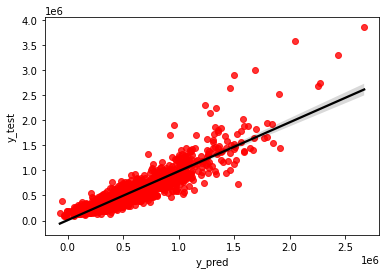

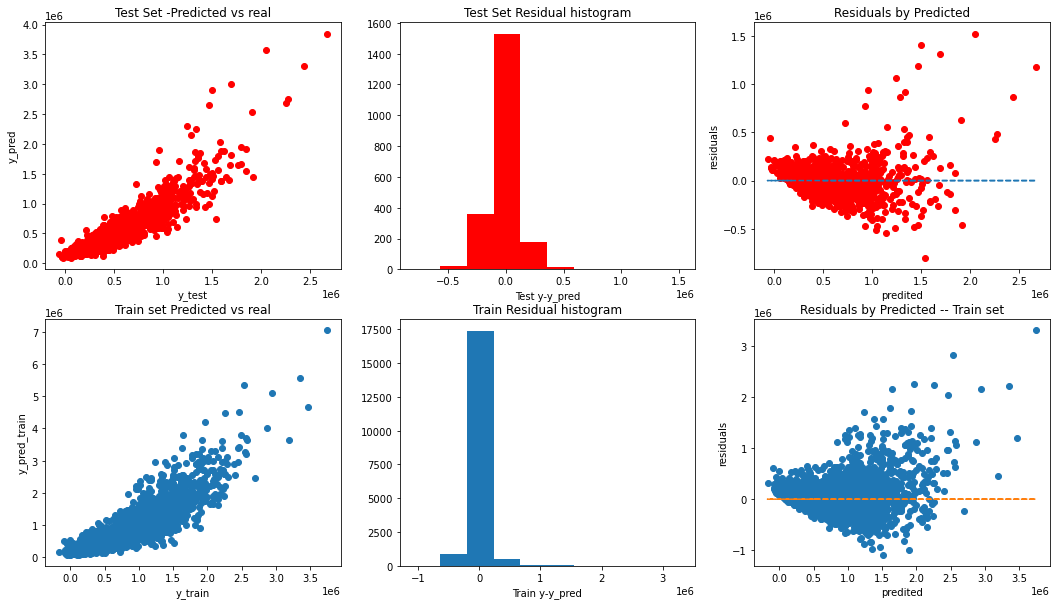

In [1337]:

sns.regplot(x='y_pred',y='y_test', data=result, scatter_kws={"color": "red"}, line_kws={"color": "black"})
plot_train_vs_test(x_train=x_train,y_pred= y_pred, x_test=x_test, y_test=y_test, y_pred_train=y_pred_train)

<a id='feature_importance'></a>
<a href='#content'>back to content list</a>

In [1338]:
features_importances = pd.DataFrame(data={
    'Attribute': x_train.columns,
    'Importance': abs(model_l.coef_)
})
features_importances = features_importances.sort_values(by='Importance', ascending=False)

features_importances = features_importances[features_importances['Attribute'].str.startswith('zip') != True]
features_importances

,Attribute,Importance
3,waterfront,800416.167057
5,grade,70779.057632
6,sqft_basement,34404.981300
0,bedrooms,32206.512908
1,bathrooms,21825.406624
4,condition,21331.117471
7,yr_built,1315.214218
2,sqft_living,197.627520


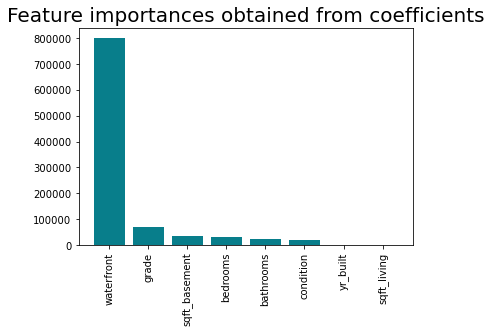

In [1339]:
plt.bar(x=features_importances['Attribute'], height=features_importances['Importance'], color='#087E8B')
plt.title('Feature importances obtained from coefficients', size=20)
plt.xticks(rotation='vertical')
plt.show()

In [1340]:
R2_train=r2_score(y_train,y_pred_train)
R2_test=r2_score(y_test,y_pred)
print (R2_train)
print(R2_test)

0.8008493813130864
0.8142659603323411
